# Feed some Food
Trying to feed some tasty text-tensors to our feedforward model

In [4]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# only for transforms
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

### 0 Config and Parameters

In [3]:
# config
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

# hyperparameters
in_dim = 10001
hidden_dim = 100
out_dim = 4
epochs = 20 #90
batch = 200
lr = 0.01

### 1 Dataloader

In [4]:
class MyDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)

In [20]:
data = pd.read_pickle('Data/lizzyschlemmermeyer.pkl')
# drop id column
data = data.drop(['ID'], axis=1)
data.head()

,vector,stance
0,"[[tensor(0., dtype=torch.float64), tensor(0., ...",[tensor(0)]
1,"[[tensor(0., dtype=torch.float64), tensor(0., ...",[tensor(1)]
2,"[[tensor(0., dtype=torch.float64), tensor(0., ...",[tensor(0)]
3,"[[tensor(0., dtype=torch.float64), tensor(0., ...",[tensor(0)]
4,"[[tensor(0., dtype=torch.float64), tensor(0., ...",[tensor(2)]


In [18]:
data['vector'][0]

tensor([[0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)

In [21]:
train, test = train_test_split(data, test_size=0.2)
print(train.__len__())

13936


In [32]:
train_loader = DataLoader(dataset=train, batch_size=batch, shuffle=False, collate_fn=collate_batch)
test_loader = DataLoader(dataset=test, batch_size=batch, shuffle=False, num_workers=1)

### 2 MLP Layers and Activation

In [9]:
# define neural net
class NN(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super(NN, self).__init__()
        # define layers
        self.l1 = nn.Linear(in_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_dim, out_dim)
    
    # applies layers with sample x
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        return out

model = NN(in_dim, hidden_dim, out_dim).to(device)

### 3 Loss and Optimizer

In [10]:
criterion = nn.CrossEntropyLoss() # this also applies softmax for us
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

### 4 Training Loop and Batch Size

In [11]:
print(train.__len__())

13936


In [39]:
# one step for each batch
n_steps = train.__len__()
idx = 0
cuda0 = torch.device('cuda:0')
loss_vals=  []

for epoch in range(epochs):
    epoch_loss= []
    # loop over & unpack batches
    for i in enumerate(train_loader): #.iterrows():
        vector = (i[1][0]).to(device) # data
        stance = (i[1][1]).to(device) # label
        
        # forward pass
        outputs = model(vector.float())
        loss = criterion(outputs, stance)
        epoch_loss.append(loss.item())
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # print loss every 100th step\\\  (idx+1) % 100
        if (idx+1) % 11 == 0:
            print(f"epoch {epoch+1} / {epochs}, step {idx+1}/{n_steps}, loss = {loss.item():.4}")
            idx+=1
    # append avg loss per epoch to loss vals    
    loss_vals.append(sum(epoch_loss)/len(epoch_loss))



KeyError: 3116

In [16]:
print(outputs)

tensor([[-14.9725, -23.9889, -18.6390,  18.3463]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


### 5 Evaluation

In [19]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    test_loss_vals = []
    
    for epoch in range(epochs):
        test_epoch_loss= []
        # loop over & unpack batches
        for i in test.iterrows():

            vector = (i[1][0]).to(device) # data
            stance = (i[1][1]).to(device) # label

            # test the trained model
            outputs = model(vector.float())
            loss = criterion(outputs, stance)
            test_epoch_loss.append(loss.item())
            
            # value, index
            _, predictions = torch.max(outputs, 1)
            n_samples += stance.shape[0] # gives us n of samples of current batch
            n_correct += (predictions == stance).sum().item()
        # append avg loss per epoch to loss vals    
        test_loss_vals.append(sum(test_epoch_loss)/len(test_epoch_loss))

    # accuracy in percent
    acc = 100.0 * n_correct / n_samples
    if acc < 69.0:
        print(f'accuracy = {acc}')
    elif acc >= 69.0:
        print(f'accuracy = {acc}, 🎉🎉🎉')
        

accuracy = 62.05510907003444


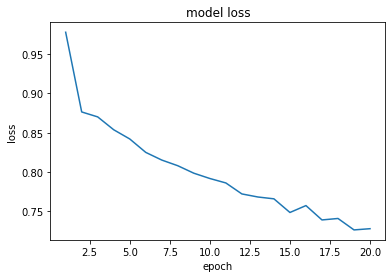

In [20]:
def my_plot(epochs, loss):
    plt.plot(epochs, loss)
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
# plot loss when finished
my_plot(np.linspace(1, epochs, epochs).astype(int), loss_vals)

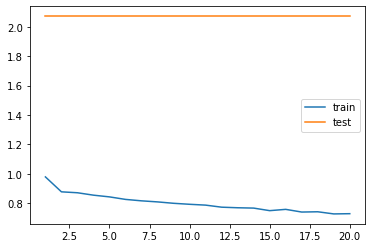

In [21]:
plt.plot(np.linspace(1, epochs, epochs).astype(int), loss_vals)
plt.plot(np.linspace(1, epochs, epochs).astype(int), test_loss_vals)
plt.legend(['train', 'test'])
plt.show()

In [21]:
# save the model
torch.save(model.state_dict(), "./kowalsky.pth")

### Visualisation

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

y_pred = []
y_true = []

# iterate over test data
for i in test.iterrows():
        inputs = (i[1][0]).to(device) # data
        labels = (i[1][1]).to(device) # label
        
        output = model(inputs.float()) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth


<AxesSubplot:>

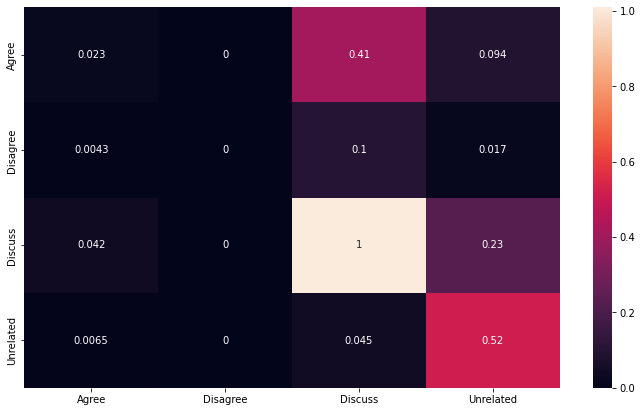

In [23]:
# constant for classes
classes = ('Agree', 'Disagree', 'Discuss', 'Unrelated')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *2.5, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)